Deskripsi Library Yang Digunakan

In [1]:
import pandas as pd
import numpy as np

# Library Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Library Analisis Data Deret Waktu
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Library Untuk Forecasting
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

Memanggil DataSet

In [2]:
df = pd.read_excel('CO2 dataset.xlsx')

Deskripsi DataSet

In [3]:
df.head()

,Year,CO2
0,1800,0.00568
1,1801,0.00561
2,1802,0.00555
3,1803,0.00548
4,1804,0.00542


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    215 non-null    int64  
 1   CO2     215 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.5 KB


Transform Data

In [5]:
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

In [6]:
df.set_index(['Year'], inplace=True)

In [7]:
df.head()

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


In [8]:
df.index.min(), df.index.max()

(Timestamp('1800-01-01 00:00:00'), Timestamp('2014-01-01 00:00:00'))

In [9]:
if (df.index.max() - df.index.min() == 214):
    print('Data Is Continuous')

In [10]:
df.index.freq='YS'

Analisa Time Series

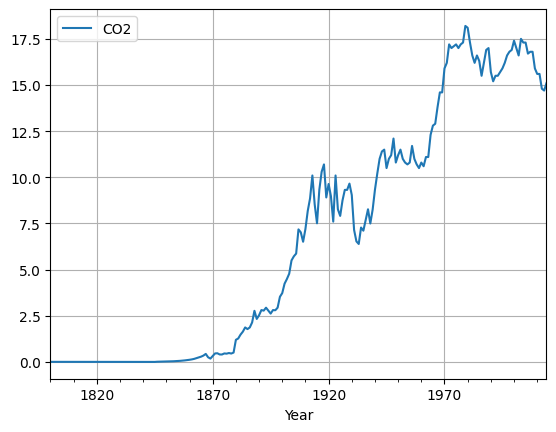

In [11]:
df.plot(grid=True);

In [12]:
train_df = df.loc[:'1991-01-01']
test_df = df.loc['1992-01-01':]

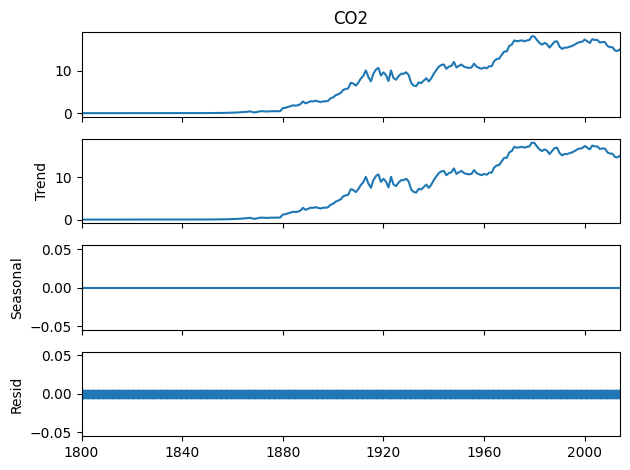

In [13]:
decompose_add = seasonal_decompose(df['CO2'])
decompose_add.plot();

In [14]:
def adf_test(timeseries):
    print ('Hasil Test Dari Dickey-Fuller:')
    print ('----------------------------------------------')
    adftest = adfuller(timeseries)
    adf_output = pd.Series(adftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in adftest[4].items():
        adf_output['Critical Value (%s)'%key] = value
    print (adf_output)

adf_test(df.values)

Hasil Test Dari Dickey-Fuller:
----------------------------------------------
Test Statistic                  -0.378463
p-value                          0.913633
#Lags Used                       0.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64


In [15]:
diff_df = df.diff()
diff_df.head()

,CO2
Year,
1800-01-01,NaN
1801-01-01,-0.00007
1802-01-01,-0.00006
1803-01-01,-0.00007
1804-01-01,-0.00006


In [16]:
diff_df.dropna(inplace=True)

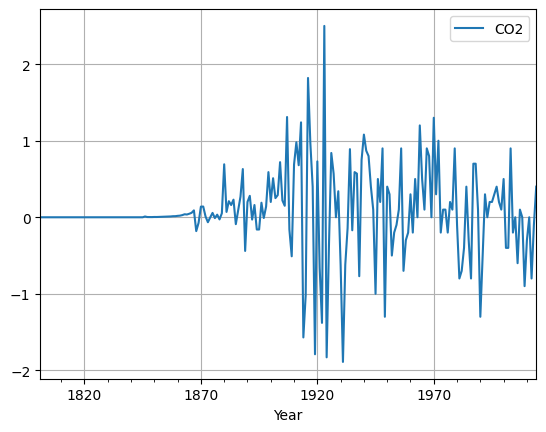

In [17]:
diff_df.plot(grid=True);

In [18]:
adf_test(diff_df)

Hasil Test Dari Dickey-Fuller:
----------------------------------------------
Test Statistic                  -3.780005
p-value                          0.003119
#Lags Used                      15.000000
Number of Observations Used    198.000000
Critical Value (1%)             -3.463815
Critical Value (5%)             -2.876251
Critical Value (10%)            -2.574611
dtype: float64


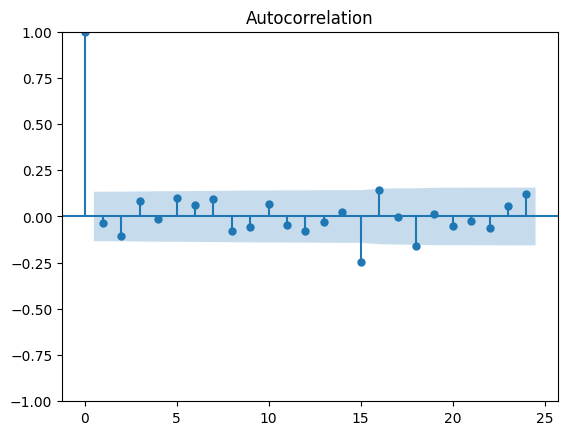

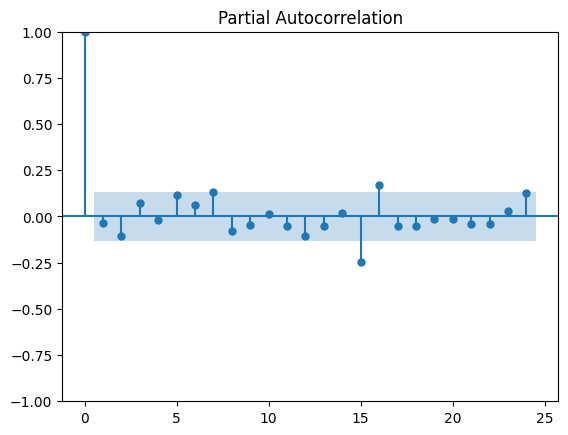

In [19]:
plot_acf(diff_df);
plot_pacf(diff_df);

Single Exponential Smoothing

In [20]:
single_exp = SimpleExpSmoothing(train_df).fit()
single_exp_train_pred = single_exp.fittedvalues
single_exp_test_pred = single_exp.forecast(23)

<Axes: xlabel='Year'>

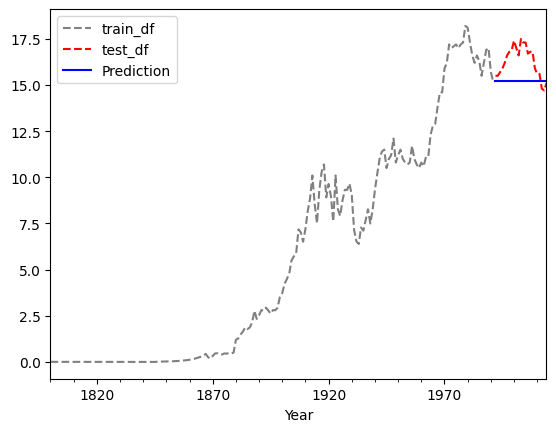

In [21]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
single_exp_test_pred.plot(color='b', legend=True, label='Prediction')

In [22]:
print('Train RMSE:',mean_squared_error(train_df, single_exp_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, single_exp_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, single_exp_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df, single_exp_test_pred))

Train RMSE: 0.564692002680021
Test RMSE: 1.3429113022690744
Train MAPE: 0.08470457297144991
Test MAPE: 0.06861466412071275


Double Exponential Smoothing

In [46]:
double_exp = ExponentialSmoothing(train_df, trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=29, damped_trend=False).fit()
double_exp_train_pred = double_exp.fittedvalues
double_exp_test_pred = double_exp.forecast(23)

<Axes: xlabel='Year'>

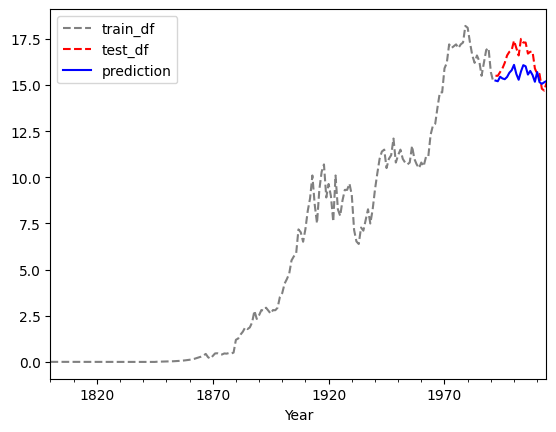

In [47]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
double_exp_test_pred.plot(color='b', legend=True, label='prediction')

In [48]:
print('Train RMSE:',mean_squared_error(train_df, double_exp_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, double_exp_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, double_exp_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df, double_exp_test_pred))

Train RMSE: 0.5576263311586229
Test RMSE: 0.9739218268464459
Train MAPE: 14.72268617058503
Test MAPE: 0.050781568455286974


ARIMA

In [54]:
ar = ARIMA(train_df, order=(10,1,10)).fit()
ar_train_pred = ar.fittedvalues
ar_test_pred = ar.forecast(23)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='Year'>

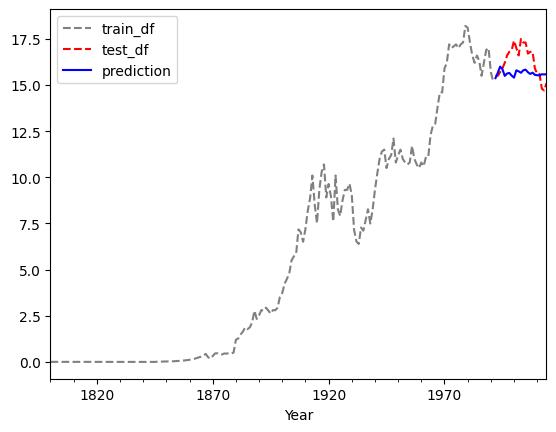

In [55]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
ar_test_pred.plot(color='b', legend=True, label='prediction')

In [56]:
print('Train RMSE:',mean_squared_error(train_df, ar_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, ar_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, ar_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df, ar_test_pred))

Train RMSE: 0.49184184829420685
Test RMSE: 1.0281209162147866
Train MAPE: 0.08251401840668722
Test MAPE: 0.05143168691554321


Perbandingan Algoritma

In [57]:
comparision_df = pd.DataFrame(data=[
    ['Single Exp Smoothing', 1.3429 , 0.0686],
    ['Double Exp Smoothing', 0.9739, 0.0507],
    ['ARIMA', 1.0281, 0.0514],
    ],
    columns=['Model','RMSE','MAPE'])

comparision_df.set_index('Model', inplace=True)

In [58]:
comparision_df.sort_values(by='RMSE')

,RMSE,MAPE
Model,,
Double Exp Smoothing,0.9739,0.0507
ARIMA,1.0281,0.0514
Single Exp Smoothing,1.3429,0.0686


In [65]:
double_exp = ExponentialSmoothing(df, trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=29, damped_trend=False).fit()
double_exp_pred = double_exp.forecast(30)

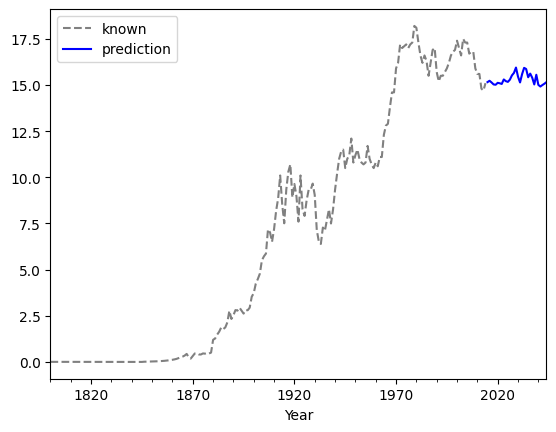

In [66]:
df['CO2'].plot(style='--', color='gray', legend=True, label='known')
double_exp_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [69]:
import pickle

In [70]:
pickle.dump(ar,open('prediksi_co2.sav', 'wb'))